# Setting

In [1]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
import seaborn as sns
import optuna
import os
import category_encoders as ce
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.model_selection import *
from sklearn.metrics import *

# Import Data

In [2]:
%%time

train = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')
# original = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

# original['Depression'] = original['Depression'].map({'No':0, 'Yes':1})

train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)

# train = pd.concat(objs = [train, original])

CPU times: user 657 ms, sys: 107 ms, total: 763 ms
Wall time: 1.15 s


# Feature Engineering

In [3]:
def binding_age(df, cols):
    bins = [i for i in range(0, 105, 5)]
    labels = [f'{i}-{i+4}' for i in range(0, 100, 5)]
    df['Age_Bind'] = pd.cut(df[cols], bins=bins, labels=labels)
    return df

In [4]:
def age_statistics(train, test):
    age_bind_depression = train.groupby('Age_Bind')['Depression'].mean()
    age_bind_ratio = train['Age_Bind'].value_counts(normalize = True)
    age_bind_depression_cali = pd.merge(age_bind_depression, age_bind_ratio, how = 'inner', left_on = age_bind_depression.index, right_on = age_bind_ratio.index).dropna()
    age_bind_depression_cali = age_bind_depression_cali.rename(columns = {"key_0":'Age_Bind', "Depression" : "Depression Rate"})
    age_bind_depression_cali['Calibrate Score'] = age_bind_depression_cali['Depression Rate'] * age_bind_depression_cali['proportion']
    
    for col in age_bind_depression_cali.columns:
        age_bind_depression_cali[col] = age_bind_depression_cali[col].astype('str')
    
    train = pd.merge(train, age_bind_depression_cali, how = 'left', on = 'Age_Bind')
    test = pd.merge(test, age_bind_depression_cali, how = 'left', on = 'Age_Bind')
    return train, test

In [5]:
train = binding_age(train, 'Age')
test = binding_age(test, 'Age')
train, test = age_statistics(train, test)

In [6]:
def cleaning_student(train, test):
    # 'Working Professional or Student' 열에서 'Student'인 경우 Profession을 'Student'로 설정
    train.loc[train['Working Professional or Student'] == 'Student', 'Profession'] = "Student"
    test.loc[test['Working Professional or Student'] == 'Student', 'Profession'] = "Student"
    return train, test

train, test = cleaning_student(train, test)

# Null Checking

In [7]:
# for col in train.columns:
#     if train[col].nunique() == 5:
#         print(f"Number of {col} ===> [{train[col].nunique()}]")
        
train[['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Financial Stress']].isna().sum() / train.shape[0]

Academic Pressure     0.801727
Work Pressure         0.198422
Study Satisfaction    0.801727
Job Satisfaction      0.198365
Financial Stress      0.000028
dtype: float64

### [Null] 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction'

In [8]:
def print_statistics_by_group(train, column_name):
    # 결측치가 없는 데이터 처리
    not_null_data = train.loc[~train[column_name].isna(), :]
    # 그룹별 통계량 계산
    not_null_stats = not_null_data.groupby('Working Professional or Student')[column_name].agg(['mean', 'size'])

    # 결측치가 있는 데이터 처리
    null_data = train.loc[train[column_name].isna(), :]
    # 그룹별 통계량 계산 (결측치가 있는 경우)
    null_stats = null_data.groupby('Working Professional or Student')[column_name].agg(['mean', 'size'])
    
    # 출력
    print(f"Statistics for {column_name}:")
    print("Not Null Data Statistics:")
    display(not_null_stats)
    print("\nNull Data Statistics:")
    display(null_stats)
    print("\n")

# 예시로 각 컬럼에 대해 통계 확인하기
columns_to_check = ['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Financial Stress']

for column in columns_to_check:
    print_statistics_by_group(train, column)

Statistics for Academic Pressure:
Not Null Data Statistics:


,mean,size
Working Professional or Student,,
Student,3.142227,27892
Working Professional,3.400000,5



Null Data Statistics:


,mean,size
Working Professional or Student,,
Student,NaN,9
Working Professional,NaN,112794




Statistics for Work Pressure:
Not Null Data Statistics:


,mean,size
Working Professional or Student,,
Student,4.000000,3
Working Professional,2.998971,112779



Null Data Statistics:


,mean,size
Working Professional or Student,,
Student,NaN,27898
Working Professional,NaN,20




Statistics for Study Satisfaction:
Not Null Data Statistics:


,mean,size
Working Professional or Student,,
Student,2.944893,27891
Working Professional,3.166667,6



Null Data Statistics:


,mean,size
Working Professional or Student,,
Student,NaN,10
Working Professional,NaN,112793




Statistics for Job Satisfaction:
Not Null Data Statistics:


,mean,size
Working Professional or Student,,
Student,2.375000,8
Working Professional,2.974446,112782



Null Data Statistics:


,mean,size
Working Professional or Student,,
Student,NaN,27893
Working Professional,NaN,17




Statistics for Financial Stress:
Not Null Data Statistics:


,mean,size
Working Professional or Student,,
Student,3.139867,27898
Working Professional,2.951666,112798



Null Data Statistics:


,mean,size
Working Professional or Student,,
Student,NaN,3
Working Professional,NaN,1


In [9]:
# not_null_work_pressure = train.loc[~train['Work Pressure'].isna(), :]
# not_null_work_pressure.groupby('Working Professional or Student')['Work Pressure'].agg(['mean', 'size'])

# not_null_work_pressure[not_null_work_pressure['Working Professional or Student'] != 'Student']

# null_work_pressure = train.loc[train['Work Pressure'].isna(), :]
# null_work_pressure.groupby('Working Professional or Student')['Work Pressure'].agg(['mean', 'size'])

In [10]:
def fill_null(train, test, cols):
    for col in cols:
        if col in ['Academic Pressure', 'Study Satisfaction']:
            # 학생 그룹에 대해 결측치 처리
            for df in [train, test]:
                avg_value = round(df[df['Working Professional or Student'] == 'Student'][col].mean())
                df.loc[df['Working Professional or Student'] == 'Student', col] = df.loc[df['Working Professional or Student'] == 'Student', col].fillna(avg_value)

        elif col in ['Work Pressure', 'Job Satisfaction']:
            # 직장인 그룹에 대해 결측치 처리
            for df in [train, test]:
                avg_value = round(df[df['Working Professional or Student'] != 'Student'][col].mean())
                df.loc[df['Working Professional or Student'] != 'Student', col] = df.loc[df['Working Professional or Student'] != 'Student', col].fillna(avg_value)

        elif col == "CGPA":
            # 학생 그룹에 대해 결측치 처리 (CGPA)
            for df in [train, test]:
                avg_value = df[df['Working Professional or Student'] == 'Student'][col].mean()
                df.loc[df['Working Professional or Student'] == 'Student', col] = df.loc[df['Working Professional or Student'] == 'Student', col].fillna(avg_value)

    return train, test

# 사용할 컬럼 목록
pressure_satisfaction_cols = ['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'CGPA']

train, test = fill_null(train, test, pressure_satisfaction_cols)

In [11]:
# train[pressure_satisfaction_cols] = train[pressure_satisfaction_cols].fillna(0)
# test[pressure_satisfaction_cols] = test[pressure_satisfaction_cols].fillna(0)

# Feature Enginnering
### Total Score (Pressure + Satisfaction)

In [12]:
train[['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Depression']].corr(method = 'spearman')

,Academic Pressure,Work Pressure,Study Satisfaction,Job Satisfaction,Depression
Academic Pressure,1.000000,-0.120468,-0.116722,0.015238,0.472382
Work Pressure,-0.120468,1.000000,0.000000,-0.037195,0.215941
Study Satisfaction,-0.116722,0.000000,1.000000,-0.121628,-0.168130
Job Satisfaction,0.015238,-0.037195,-0.121628,1.000000,-0.170005
Depression,0.472382,0.215941,-0.168130,-0.170005,1.000000


<Axes: >

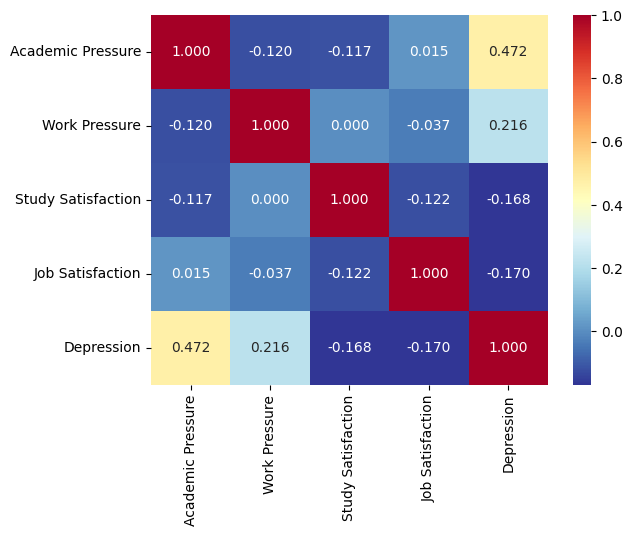

In [13]:
corr_df = train[['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Depression']].corr(method = 'spearman')

sns.heatmap(corr_df, annot = True, fmt = '.3f', cmap = 'RdYlBu_r')

In [14]:
# 상관 행렬 계산 (Spearman 방법)
tmp_train = train[['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Depression']].copy()
tmp_test = test[['Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction']].copy()

corr_df = tmp_train.corr(method='spearman')

# 각 column에 대한 상관 계수 추출
corr_academic = corr_df.loc['Academic Pressure', 'Depression']
corr_work = corr_df.loc['Work Pressure', 'Depression']
corr_study = corr_df.loc['Study Satisfaction', 'Depression']
corr_job = corr_df.loc['Job Satisfaction', 'Depression']

# total_score 생성
train['total_score'] = (tmp_train['Academic Pressure'].fillna(0) * corr_academic) + \
                        (tmp_train['Work Pressure'].fillna(0) * corr_work) + \
                        (tmp_train['Study Satisfaction'].fillna(0) * corr_study) + \
                        (tmp_train['Job Satisfaction'].fillna(0) * corr_job)

test['total_score'] = (tmp_test['Academic Pressure'].fillna(0) * corr_academic) + \
                        (tmp_test['Work Pressure'].fillna(0) * corr_work) + \
                        (tmp_test['Study Satisfaction'].fillna(0) * corr_study) + \
                        (tmp_test['Job Satisfaction'].fillna(0) * corr_job)

In [15]:
train[['total_score', 'Depression']].corr()

,total_score,Depression
total_score,1.000000,0.556837
Depression,0.556837,1.000000


In [16]:
degree = {
    "BCom": "B.Com", "B.Com": "B.Com", "B.Comm": "B.Com",
    "B.Tech": "B.Tech", "BTech": "B.Tech", "B.T": "B.Tech",
    "BSc": "B.Sc", "B.Sc": "B.Sc", "Bachelor of Science": "B.Sc",
    "BArch": "B.Arch", "B.Arch": "B.Arch",
    "BA": "B.A", "B.A": "B.A",
    "BBA": "BBA", "BB": "BBA",
    "BCA": "BCA",
    "BE": "BE",
    "BEd": "B.Ed", "B.Ed": "B.Ed",
    "BPharm": "B.Pharm", "B.Pharm": "B.Pharm",
    "BHM": "BHM",
    "LLB": "LLB", "LL B": "LLB", "LL BA": "LLB", "LL.Com": "LLB", "LLCom": "LLB",
    "MCom": "M.Com", "M.Com": "M.Com",
    "M.Tech": "M.Tech", "MTech": "M.Tech", "M.T": "M.Tech",
    "MSc": "M.Sc", "M.Sc": "M.Sc", "Master of Science": "M.Sc",
    "MBA": "MBA",
    "MCA": "MCA",
    "MD": "MD",
    "ME": "ME",
    "MEd": "M.Ed", "M.Ed": "M.Ed",
    "MArch": "M.Arch", "M.Arch": "M.Arch",
    "MPharm": "M.Pharm", "M.Pharm": "M.Pharm",
    "MA": "MA", "M.A": "MA",
    "MPA": "MPA",
    "LLM": "LLM",
    "PhD": "PhD",
    "MBBS": "MBBS",
    "CA": "CA",
    "Class 12": "Class 12", "12th": "Class 12",
    "Class 11": "Class 11", "11th": "Class 11"
}

train['Degree'] = train['Degree'].map(degree)
test['Degree'] = test['Degree'].map(degree)

train['Degree'].unique()

array(['BHM', 'LLB', 'B.Pharm', 'BBA', 'MCA', 'MD', 'B.Sc', 'ME',
       'B.Arch', 'BCA', 'BE', 'MA', 'B.Ed', 'B.Com', 'MBA', 'M.Com', nan,
       'B.A', 'Class 12', 'M.Tech', 'PhD', 'M.Ed', 'M.Sc', 'B.Tech',
       'LLM', 'MBBS', 'M.Pharm', 'MPA', 'Class 11', 'M.Arch'],
      dtype=object)

# Clean Data

In [17]:
def clean_columns(df, column, valid_categories):
    df[column] = df[column].apply(lambda x : x if x in valid_categories else 'Noise')
    return df

valid_sleep_duration = ["Less than 5 hours", "5-6 hours", "6-7 hours", "7-8 hours", "More than 8 hours"]
valid_dietary_habits = ['Healthy', 'Moderate', 'Unhealthy']

train = clean_columns(train, 'Sleep Duration', valid_sleep_duration)
train = clean_columns(train, 'Dietary Habits', valid_dietary_habits)
test = clean_columns(test, 'Sleep Duration', valid_sleep_duration)
test = clean_columns(test, 'Dietary Habits', valid_dietary_habits)

In [18]:
def removieNoise(df, columns, threshold=100):
    
    for column in columns:
        value_counts = df[column].value_counts()
        low_freq_categories = value_counts[value_counts < threshold].index
        df[column] = df[column].apply(lambda x: x if x not in low_freq_categories else 'Other')
    
    return df

train = removieNoise(train, ['Name', 'City', 'Profession', 'Degree'])
test = removieNoise(test, ['Name', 'City', 'Profession', 'Degree'])

In [19]:
# cat_c = [col for col in train.columns if col != 'Depression']
# train[cat_c].dtypes
train = train.fillna('None').astype('str')
test = test.fillna('None').astype('str')

# Catboost Model

In [20]:
%%time

y = train['Depression']
X = train.drop(['Depression'], axis = 1)

def CAT_(X, y, test, catboost_params, fold=10, seed=0):
    SKF = StratifiedKFold(n_splits=fold, shuffle = True, random_state = seed)
    train_accuracies = []
    valid_accuracies = []
    test_predictions = []
    oof_predictions = np.zeros(len(X))
    
    test_pool = Pool(test, cat_features = X.columns.values)
    
    for fold, (train_idx, val_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_pool = Pool(X_train, y_train, cat_features = X.columns.values)
        val_pool = Pool(X_val, y_val, cat_features = X.columns.values)
        
        model = CatBoostClassifier(**catboost_params, random_state = seed, verbose = 0)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
        train_predictions = model.predict(train_pool)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_accuracies.append(train_accuracy)
        
        val_predictions = model.predict(val_pool)
        valid_accuracy = accuracy_score(y_val, val_predictions)
        valid_accuracies.append(valid_accuracy)
        
        oof_predictions[val_idx] = model.predict_proba(val_pool)[:,1]
        
        test_fold_pred = model.predict_proba(test_pool)[:,1]
        test_predictions.append(test_fold_pred)
        
        print(f'Fold {fold + 1} Train Accuracy: {train_accuracy:.3f}, Valid Accuracy: {valid_accuracy:.3f}')
    
    overall_train_accuracy = np.mean(train_accuracies)
    overall_valid_accuracy = np.mean(valid_accuracies)
    
    print(f'Overall Train Accuracy: {overall_train_accuracy:.3f}')
    print(f'Overall Valid Accuracy: {overall_valid_accuracy:.3f}')
    
    mean_oof_preds = np.mean(oof_predictions)
    mean_test_preds = np.mean(test_predictions, axis=0)
    
    return mean_oof_preds, mean_test_preds

CPU times: user 34.6 ms, sys: 872 µs, total: 35.5 ms
Wall time: 34.9 ms


# Train

In [21]:
# Params4 = {
#     'loss_function': 'Logloss',
#     'eval_metric': 'AUC',
#     'learning_rate': 0.08114394459649094,
#     'iterations': 1000,
#     'depth': 6,
#     'random_strength':0,
#     'l2_leaf_reg': 0.7047064221215757,
#     'task_type': 'GPU'} # LB : 0.94381

# meanOFF, meanTest = CAT_(X, y, test, Params4, fold=10, seed = 0)

In [22]:
# my_Params1 = {
#     'loss_function': 'Logloss',
#     'eval_metric': 'AUC',
#     'learning_rate': 0.07788937579814562,
#     'iterations': 1744,
#     'depth': 4,
#     'random_strength':100,
#     'l2_leaf_reg': 0.007488708299233241,
#     'task_type': 'GPU'} # LB : 0.94381


# meanOFF, meanTest = CAT_(X, y, test, my_Params1, fold=10, seed = 0)

In [23]:
import gc
gc.collect()

30

# Submit

In [24]:
# %%time

# sample['Depression'] = np.round(meanTest)

# sample.to_csv('submission.csv', index=False)

# sample.head()

# Optuna HPO

In [25]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool
import numpy as np


y = train['Depression']
X = train.drop(['Depression'], axis = 1)

# 주어진 하이퍼파라미터 Params4를 기준으로 범위 재설정
def objective(trial):
    # Optuna에서 튜닝할 하이퍼파라미터 범위 정의
#     catboost_params = {
#         'loss_function': 'Logloss',
#         'eval_metric': 'AUC',
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),  # 학습률 범위
#         'iterations': trial.suggest_int('iterations', 500, 2000),  # 반복 횟수
#         'depth': trial.suggest_int('depth', 4, 12),  # 트리 깊이 범위
#         'random_strength': trial.suggest_int('random_strength', 0, 100),  # 랜덤 강도
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e2),  # L2 정규화
#         'task_type': 'GPU',
#         'random_state': 0,
#         'verbose': 0
#     }

    catboost_params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),  # 좁힌 학습률 범위
        'iterations': trial.suggest_int('iterations', 900, 2000),  # 1000에서 2000 사이
        'depth': trial.suggest_int('depth', 3, 8),  # 깊이는 4에서 6 사이로 제한
        'random_strength': trial.suggest_int('random_strength', 0, 100),  # 랜덤 강도 범위
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e1),  # L2 정규화 범위 좁힘
        'task_type': 'GPU',
        'random_state': 0,
        'verbose': 0
    }
    
    # Stratified KFold 설정
    fold = 10
    SKF = StratifiedKFold(n_splits=fold, shuffle=True, random_state=0)
    train_accuracies = []
    valid_accuracies = []
    
    oof_predictions = np.zeros(len(X))  # Out of fold 예측값
    
    for fold_idx, (train_idx, val_idx) in enumerate(SKF.split(X, y)):
#         print(f"\n--- Fold {fold_idx + 1} ---")  # 각 fold마다 시작 로그
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_pool = Pool(X_train, y_train, cat_features=X.columns.values.tolist())
        val_pool = Pool(X_val, y_val, cat_features=X.columns.values.tolist())
        
        model = CatBoostClassifier(**catboost_params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)
        
        # 훈련 데이터 예측
        train_predictions = model.predict(train_pool)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_accuracies.append(train_accuracy)
        
        # 검증 데이터 예측
        val_predictions = model.predict(val_pool)
        valid_accuracy = accuracy_score(y_val, val_predictions)
        valid_accuracies.append(valid_accuracy)
        
        oof_predictions[val_idx] = model.predict_proba(val_pool)[:, 1]  # OOF 예측값
        
        # 각 fold의 결과 출력
#         print(f"Train Accuracy for Fold {fold_idx + 1}: {train_accuracy:.3f}")
#         print(f"Validation Accuracy for Fold {fold_idx + 1}: {valid_accuracy:.3f}")
        
    overall_train_accuracy = np.mean(train_accuracies)
    overall_valid_accuracy = np.mean(valid_accuracies)
    
    print(f"\nOverall Train Accuracy: {overall_train_accuracy:.3f}")
    print(f"Overall Validation Accuracy: {overall_valid_accuracy:.3f}")
    
    # 최적화할 값 반환 (validation accuracy를 최대로)
    return overall_valid_accuracy  # Valid accuracy를 반환해서 최적화

In [26]:
%%time
# Optuna로 최적화 수행
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=30)

[I 2024-11-15 11:23:29,099] A new study created in memory with name: no-name-81116025-0502-4151-894a-950da1c2c5ef
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 11:29:35,280] Trial 0 finished with value: 0.9309310589907603 and parameters: {'learning_rate': 0.0021050097467122473, 'iterations': 1208, 'depth': 6, 'random_strength': 10


Overall Train Accuracy: 0.932
Overall Validation Accuracy: 0.931


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 11:30:39,346] Trial 1 finished with value: 0.923909026297086 and parameters: {'learning_rate': 0.0025217006621693953, 'iterations': 1428, 'depth': 7, 'random_strength': 71, 'l2_leaf_reg': 7.558130555958174e-05}. Best is trial 0 with value: 0.9309310589907603.



Overall Train Accuracy: 0.925
Overall Validation Accuracy: 0.924


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 11:39:15,703] Trial 2 finished with value: 0.9397512437810944 and parameters: {'learning_rate': 0.02401857134749184, 'iterations': 1654, 'depth': 8, 'random_strength': 34, 'l2_leaf_reg': 4.122181280175975}. Best is trial 2 with value: 0.9397512437810944.



Overall Train Accuracy: 0.946
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 11:43:25,901] Trial 3 finished with value: 0.9393461265103056 and parameters: {'learning_rate': 0.025402969413247517, 'iterations': 1253, 'depth': 3, 'random_strength': 88, 'l2_leaf_reg': 0.0029736082911841796}. Best is trial 2 with value: 0.9397512437810944.



Overall Train Accuracy: 0.941
Overall Validation Accuracy: 0.939


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 11:54:28,142] Trial 4 finished with value: 0.9376332622601279 and parameters: {'learning_rate': 0.003639414420253569, 'iterations': 1919, 'depth': 6, 'random_strength': 60, 'l2_leaf_reg': 9.085960394793663}. Best is trial 2 with value: 0.9397512437810944.



Overall Train Accuracy: 0.940
Overall Validation Accuracy: 0.938


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:00:32,482] Trial 5 finished with value: 0.9399289267945985 and parameters: {'learning_rate': 0.023518459479350384, 'iterations': 1422, 'depth': 4, 'random_strength': 70, 'l2_leaf_reg': 3.838379783507004}. Best is trial 5 with value: 0.9399289267945985.



Overall Train Accuracy: 0.942
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:04:16,462] Trial 6 finished with value: 0.9391968727789622 and parameters: {'learning_rate': 0.028592527361861412, 'iterations': 1106, 'depth': 3, 'random_strength': 78, 'l2_leaf_reg': 0.23880858683326536}. Best is trial 5 with value: 0.9399289267945985.



Overall Train Accuracy: 0.941
Overall Validation Accuracy: 0.939


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:07:44,170] Trial 7 finished with value: 0.9356147832267234 and parameters: {'learning_rate': 0.007708118615797747, 'iterations': 1012, 'depth': 3, 'random_strength': 40, 'l2_leaf_reg': 0.1341805392122693}. Best is trial 5 with value: 0.9399289267945985.



Overall Train Accuracy: 0.936
Overall Validation Accuracy: 0.936


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:13:21,166] Trial 8 finished with value: 0.9334754797441367 and parameters: {'learning_rate': 0.004632395331602736, 'iterations': 1632, 'depth': 4, 'random_strength': 59, 'l2_leaf_reg': 5.528722844299595e-05}. Best is trial 5 with value: 0.9399289267945985.



Overall Train Accuracy: 0.934
Overall Validation Accuracy: 0.933


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:17:16,749] Trial 9 finished with value: 0.9394740582800283 and parameters: {'learning_rate': 0.03128253027612241, 'iterations': 1167, 'depth': 3, 'random_strength': 52, 'l2_leaf_reg': 0.85893367805875}. Best is trial 5 with value: 0.9399289267945985.



Overall Train Accuracy: 0.941
Overall Validation Accuracy: 0.939


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:20:23,118] Trial 10 finished with value: 0.9397370291400142 and parameters: {'learning_rate': 0.08964183982589624, 'iterations': 1474, 'depth': 5, 'random_strength': 3, 'l2_leaf_reg': 0.007046870612058435}. Best is trial 5 with value: 0.9399289267945985.



Overall Train Accuracy: 0.944
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:34:09,724] Trial 11 finished with value: 0.9396659559346127 and parameters: {'learning_rate': 0.015234092064358353, 'iterations': 1789, 'depth': 8, 'random_strength': 24, 'l2_leaf_reg': 8.902823465785083}. Best is trial 5 with value: 0.9399289267945985.



Overall Train Accuracy: 0.947
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:38:46,692] Trial 12 finished with value: 0.9400142146410803 and parameters: {'learning_rate': 0.062226924594135084, 'iterations': 1591, 'depth': 8, 'random_strength': 31, 'l2_leaf_reg': 1.9035049163371365}. Best is trial 12 with value: 0.9400142146410803.



Overall Train Accuracy: 0.948
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:42:31,640] Trial 13 finished with value: 0.9401279317697228 and parameters: {'learning_rate': 0.0855092126837166, 'iterations': 1417, 'depth': 5, 'random_strength': 19, 'l2_leaf_reg': 0.8137962779292169}. Best is trial 13 with value: 0.9401279317697228.



Overall Train Accuracy: 0.944
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:45:32,212] Trial 14 finished with value: 0.9402914001421463 and parameters: {'learning_rate': 0.0948055046411941, 'iterations': 1588, 'depth': 5, 'random_strength': 12, 'l2_leaf_reg': 0.030735856220480844}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.944
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:49:53,192] Trial 15 finished with value: 0.9395451314854298 and parameters: {'learning_rate': 0.057567287930069246, 'iterations': 1365, 'depth': 5, 'random_strength': 2, 'l2_leaf_reg': 0.0013315132505259798}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.944
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:53:12,346] Trial 16 finished with value: 0.9399218194740582 and parameters: {'learning_rate': 0.08883204198123337, 'iterations': 1782, 'depth': 5, 'random_strength': 17, 'l2_leaf_reg': 0.025605172676486137}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.944
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 12:58:59,322] Trial 17 finished with value: 0.9401208244491828 and parameters: {'learning_rate': 0.0453921320890574, 'iterations': 1521, 'depth': 4, 'random_strength': 14, 'l2_leaf_reg': 0.0007506424814826168}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.943
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 13:06:45,501] Trial 18 finished with value: 0.9392466240227435 and parameters: {'learning_rate': 0.00954310287080762, 'iterations': 1317, 'depth': 6, 'random_strength': 13, 'l2_leaf_reg': 0.026070942814553657}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.942
Overall Validation Accuracy: 0.939


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 13:09:41,954] Trial 19 finished with value: 0.9394811656005686 and parameters: {'learning_rate': 0.09883080308030372, 'iterations': 1750, 'depth': 7, 'random_strength': 45, 'l2_leaf_reg': 0.5361589155380884}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.946
Overall Validation Accuracy: 0.939


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 13:11:22,021] Trial 20 finished with value: 0.9239232409381662 and parameters: {'learning_rate': 0.0010554702247838551, 'iterations': 934, 'depth': 5, 'random_strength': 25, 'l2_leaf_reg': 0.045007682066707216}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.925
Overall Validation Accuracy: 0.924


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 13:17:16,570] Trial 21 finished with value: 0.9399857853589196 and parameters: {'learning_rate': 0.04777710872542511, 'iterations': 1528, 'depth': 4, 'random_strength': 12, 'l2_leaf_reg': 0.00033793948639849537}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.943
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 13:22:59,261] Trial 22 finished with value: 0.9398720682302771 and parameters: {'learning_rate': 0.040709581864456695, 'iterations': 1496, 'depth': 4, 'random_strength': 9, 'l2_leaf_reg': 0.00033266565510339205}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.943
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 13:27:17,081] Trial 23 finished with value: 0.9399573560767591 and parameters: {'learning_rate': 0.06696011606127136, 'iterations': 1990, 'depth': 4, 'random_strength': 21, 'l2_leaf_reg': 0.0013983420193082762}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.943
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 13:35:22,493] Trial 24 finished with value: 0.9398507462686568 and parameters: {'learning_rate': 0.017285067387398538, 'iterations': 1707, 'depth': 5, 'random_strength': 32, 'l2_leaf_reg': 0.005869800503664562}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.943
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 13:39:57,792] Trial 25 finished with value: 0.9396730632551528 and parameters: {'learning_rate': 0.042237773929715915, 'iterations': 1562, 'depth': 6, 'random_strength': 0, 'l2_leaf_reg': 0.0003425070117198097}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.944
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 13:43:55,186] Trial 26 finished with value: 0.939864960909737 and parameters: {'learning_rate': 0.06946426612582442, 'iterations': 1310, 'depth': 4, 'random_strength': 7, 'l2_leaf_reg': 1.8419375870127494e-05}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.943
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 13:49:42,215] Trial 27 finished with value: 0.9401492537313432 and parameters: {'learning_rate': 0.041121681672115704, 'iterations': 1852, 'depth': 5, 'random_strength': 17, 'l2_leaf_reg': 0.598699560468059}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.944
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 14:01:04,122] Trial 28 finished with value: 0.9399786780383795 and parameters: {'learning_rate': 0.015473657030618464, 'iterations': 1877, 'depth': 7, 'random_strength': 39, 'l2_leaf_reg': 0.4828193886540363}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.945
Overall Validation Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2024-11-15 14:05:16,647] Trial 29 finished with value: 0.9401421464108031 and parameters: {'learning_rate': 0.07560609986022193, 'iterations': 1851, 'depth': 5, 'random_strength': 21, 'l2_leaf_reg': 0.0704882410033988}. Best is trial 14 with value: 0.9402914001421463.



Overall Train Accuracy: 0.944
Overall Validation Accuracy: 0.940
CPU times: user 6h 8min 38s, sys: 46min 59s, total: 6h 55min 38s
Wall time: 2h 41min 47s


In [27]:
# 최적 하이퍼파라미터 출력
print(f"Best parameters: {study.best_params}")
print(f"Best validation accuracy: {study.best_value:.9f}")

Best parameters: {'learning_rate': 0.0948055046411941, 'iterations': 1588, 'depth': 5, 'random_strength': 12, 'l2_leaf_reg': 0.030735856220480844}
Best validation accuracy: 0.940291400


In [28]:
# 최적화된 파라미터로 최종 모델 학습
final_catboost_params = study.best_params

final_catboost_params.update({
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'task_type': 'GPU'
})

# # 최종 모델 훈련 및 예측 (교차 검증을 통해 예측 수행)
# fold = 10
# SKF = StratifiedKFold(n_splits=fold, shuffle=True, random_state=0)
# test_predictions = []

# for train_idx, val_idx in SKF.split(X, y):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
#     train_pool = Pool(X_train, y_train, cat_features=X.columns.values.tolist())
#     test_pool = Pool(test, cat_features=X.columns.values.tolist())
    
#     model = CatBoostClassifier(**final_catboost_params)
#     model.fit(train_pool, eval_set=(train_pool, y_train), early_stopping_rounds=50)
    
#     # 테스트 데이터 예측
#     test_fold_pred = model.predict_proba(test_pool)[:, 1]
#     test_predictions.append(test_fold_pred)

meanOFF, meanTest = CAT_(X, y, test, final_catboost_params, fold=10, seed = 0)

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 Train Accuracy: 0.944, Valid Accuracy: 0.940


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 Train Accuracy: 0.944, Valid Accuracy: 0.941


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 Train Accuracy: 0.943, Valid Accuracy: 0.939


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 Train Accuracy: 0.944, Valid Accuracy: 0.938


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 Train Accuracy: 0.944, Valid Accuracy: 0.941


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 6 Train Accuracy: 0.943, Valid Accuracy: 0.942


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 7 Train Accuracy: 0.945, Valid Accuracy: 0.942


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 8 Train Accuracy: 0.944, Valid Accuracy: 0.939


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 9 Train Accuracy: 0.943, Valid Accuracy: 0.939


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 10 Train Accuracy: 0.945, Valid Accuracy: 0.941
Overall Train Accuracy: 0.944
Overall Valid Accuracy: 0.940


In [29]:
# 결과를 'submission.csv'로 저장
sample['Depression'] = np.round(meanTest)  # 예측 결과 반올림하여 저장

# 결과 파일 저장
sample.to_csv('submission.csv', index=False)

# 제출 파일 확인
sample.head()

,id,Depression
0,140700,0.0
1,140701,0.0
2,140702,0.0
3,140703,1.0
4,140704,0.0
